# Dog Breed Classifier using InceptionV3

In [1]:
import os
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend
from tensorflow.data import AUTOTUNE
import tensorflow_datasets as tfds
import absl.logging
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Model Constants

IMAGE_SIZE = (299, 299)

### Downloading Dataset

In [3]:
trainset, testset = tfds.load('stanford_dogs', split= ['train+test[:-2000]', 'test[-2000:]'],
                                      data_dir= "dataset")

print(len(trainset), len(testset))

18580 2000


### Getting List of Breeds

In [4]:
def get_labels_list(txt_file):
    """
    Returned List will have the names of the output classes 
    on same index as their labels.
    """
    
    def cleaner(label):
        label = label.split('-')[-1]
        label = label.replace('_', ' ').replace('\n', '').title()
        return label
    
    with open(txt_file, 'r') as f:
        labels_list = f.readlines()
        
    labels_list = list(map(cleaner, labels_list))
        
    return labels_list

breeds_list = get_labels_list('dataset/stanford_dogs/0.2.0/label.labels.txt')

print(f'Total no. of dog breeds in dataset - {len(breeds_list)}')

Total no. of dog breeds in dataset - 120


## Data Preprocessing

In [5]:
def inception_pp(data):
    img_tensor = tf.cast(data['image'], tf.float32)
    img_tensor = layers.Resizing(*IMAGE_SIZE, 'bicubic')(img_tensor)
    img_tensor = tf.clip_by_value(img_tensor, 0., 255.)
    
    inp = keras.applications.inception_v3.preprocess_input(img_tensor)
    targets = tf.one_hot(data["label"], 120)
    return (inp, targets)


def improve_perf(dataset):
    """
    Function to apply preprocessing, caching and prefetching to the dataset.
    Improves overall speed of data fetching.
    """
    transforms = layers.Resizing(*IMAGE_SIZE, 'bicubic')
    
    dataset = dataset.map(inception_pp, num_parallel_calls = AUTOTUNE)
    dataset = dataset.cache("__pycache__/").prefetch(AUTOTUNE)
    return dataset

def create_batches(datasets, batch_size, num_parallel_calls = AUTOTUNE):
    "Creates mini-batches in datasets."
    
    output = []
    for ds in datasets:
        ds = ds.shuffle(1000).batch(batch_size, num_parallel_calls = num_parallel_calls)
        output.append(ds)
        
    return output

trainset = improve_perf(trainset)
testset = improve_perf(testset)

### Data Visualization

Breed:- Dhole, 118
Pixel value range: (-1.0, 1.0)
Resolution: (299, 299)


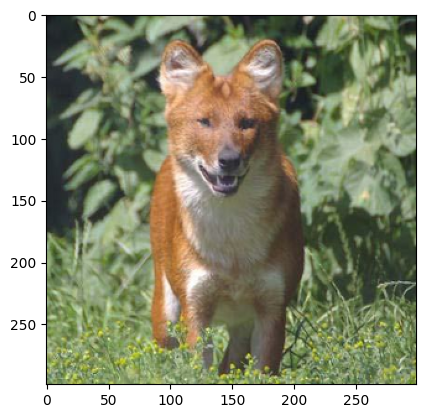

In [6]:
IMAGE_INDEX = 1

def get_example(dataset, index):
    iterator = iter(dataset)
    for _ in range(index+1):
        img, label = next(iterator)
    
    np_image = img.numpy()
    label = tf.argmax(label)
    
    return np_image, label

img, label = get_example(trainset, IMAGE_INDEX)

plt.imshow(img/2 + 0.5) # rescaled pixel values for visualization

print(f'Breed:- {breeds_list[label]}, {label}')
print('Pixel value range:', (np.amin(img), np.amax(img)))
print(f'Resolution: {img.shape[:-1]}')

# Building the classifier

### Getting the pretrained model

In [ ]:
base_model = keras.applications.inception_v3.InceptionV3(include_top = False, 
                                                         weights = "imagenet",
                                                         pooling = 'avg'
                                                        )

base_model.trainable = False
base_model.summary()

### Attaching new top layers to the base model

In [8]:
model = keras.Sequential([base_model,
                          layers.Dense(1024, kernel_initializer= 'he_normal', activation="relu"),
                          layers.Dense(120, kernel_initializer= 'he_normal', activation="softmax")],
                         name = "Dog_Breed_Classifier")

model.compile(optimizer = keras.optimizers.Adam(learning_rate= 0.001),
             loss = keras.losses.CategoricalCrossentropy(),
             metrics = ['accuracy'])

model.summary()

Model: "Dog_Breed_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 120)               123000    
                                                                 
Total params: 24,023,960
Trainable params: 2,221,176
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
# Creating batches in the dataset
trainset, testset = create_batches([trainset, testset], batch_size = 32)

### Loading the model

In [10]:
model_path = "model"
history_path = model_path + "/history.csv"

if os.path.exists(model_path):
    model = keras.models.load_model(model_path)

### Training the model

In [ ]:
save_model = keras.callbacks.ModelCheckpoint(model_path, monitor= 'val_accuracy',
                                            save_best_only = True)
save_history = keras.callbacks.CSVLogger(history_path, append=True)

absl.logging.set_verbosity(absl.logging.ERROR)   # Hiding false warning logs produced by model.save()

register = model.fit(trainset, initial_epoch = 0, epochs= 30, workers= 2, use_multiprocessing=True,
                     validation_data = testset, validation_freq= 1, callbacks= [save_model, save_history])

### Analyzing the model

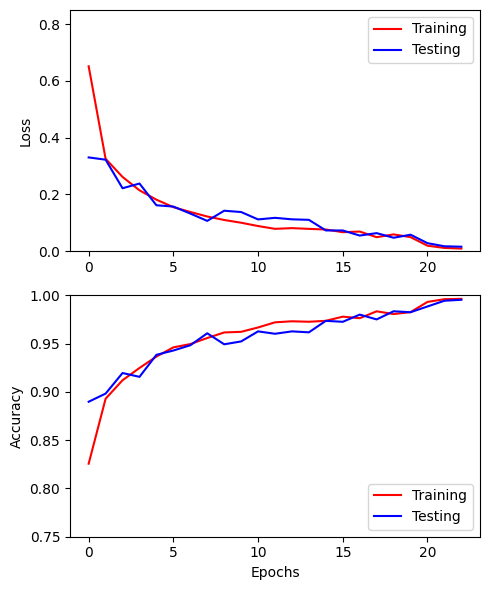

In [11]:
def load_history(path):
    "Loads history of a model from a csv file."
    acc = []
    loss = []
    val_acc = []
    val_loss = []
    if os.path.exists(path):
        with open(path, 'r') as f:
            reader = csv.reader(f, delimiter= ",")
            for line in reader:
                if not line[1].replace('.','').isnumeric(): continue
                acc.append(float(line[1]))
                loss.append(float(line[2]))
                val_acc.append(float(line[3]))
                val_loss.append(float(line[4]))
                
    return loss, acc, val_loss, val_acc


loss, accuracy, val_loss, val_accuracy = load_history(history_path)

fig, ax = plt.subplots(2, 1, figsize=(5,6))

ax[0].plot(loss, 'r', label='Training')
ax[0].plot(val_loss, 'b', label='Testing')
ax[0].set(ylabel="Loss", ylim= (0, 0.85))
ax[0].legend(loc="upper right")

ax[1].plot(accuracy, 'r', label='Training')
ax[1].plot(val_accuracy, 'b', label='Testing')
ax[1].set(xlabel="Epochs", ylabel="Accuracy", ylim= (0.75,1))
ax[1].legend(loc="lower right")

fig.tight_layout()
fig.savefig(model_path + "/history_plot.png")

In [74]:
# Add label data to the model folder
filepath = os.path.abspath('dataset/stanford_dogs/0.2.0/label.labels.txt')
model_path = os.path.abspath(model_path)
os.system(f'copy "{filepath}" "{model_path}/labels.txt" /y')

0